# This notebook is for showing the improvement you gain in the limit on $\chi$ when you account for the timing/direction information

In [2]:
from numpy import *
from PlotFuncs import *
from LabFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
from numpy import random
from scipy.integrate import cumtrapz
import cmocean
from tqdm import tqdm
from scipy.special import erf
from scipy.optimize import fsolve

def ConversionFactors(costh_samples,nbins=500):
    h,ce = histogram(costh_samples,nbins)
    cc = (ce[1:]+ce[0:-1])/2
    
    P_costh = h/sum(h) 
    
    fs = lambda P0 : 0.05-sum(0.5*(1+erf(-P0*cc/sqrt(2)))*P_costh)
    res = fsolve(fs,1.64*3)
    cval_excl = 1.64/res
    
    fs = lambda P0 : 0.05-sum(0.5*(1+erf((5-P0*cc)/sqrt(2)))*P_costh)
    res = fsolve(fs,1.64*3+5)
    cval_disc = (5+1.64)/res
    return cval_excl,cval_disc


def costh_T_05(fcosth2,lat,Tmax,nt=1000,ngen=10000):
    '''
    This function is for making an array of <cos^2(th)>_95% for an array of T
    (we call it 95% in the paper but it is actually the 5th percentile)
    
    INPUT:
    fcosth2 = the function name of the relevant angle, e.g. costh2N, costh2W, costh2Z
    lat = latitude in degrees
    Tmax = largest value of T to plot
    nt = number of values of T to plot
    ngen = number of DP polarisations to sample over
    
    OUTPUT:
    T = array of T (size=nt)
    C_05 = 5th percentile of distribution at each T (size=nt)
    '''
    costh_X = 2*random.uniform(size=ngen)-1
    phi_X = 2*pi*random.uniform(size=ngen)
    
    T = linspace(0,Tmax,nt+1)

    c1t = zeros(shape=(ngen,nt+1))

    for i in range(0,nt+1):
        c1t[:,i] = fcosth2(T[i],costh_X,phi_X,lat)

    c_av = cumtrapz(c1t,T)/T[1:]
    
    C_excl = zeros(shape=nt)
    C_disc = zeros(shape=nt)

    for i in range(0,nt):
        C_excl[i],C_disc[i] = ConversionFactors(c_av[:,i])
        
    return T[1:],C_excl,C_disc

# First do the North-pointing experiment over a range of latitudes
# The zenith-pointing is the same by symmetry when taking the same range of lat
nlats = 10
lats = linspace(35,55,nlats)
nt = 1000
CN_excl = zeros(shape=(nlats,nt))
CN_disc = zeros(shape=(nlats,nt))
for i in tqdm(range(0,nlats)):
    T,CN_excl[i,:],CN_disc[i,:] = costh_T_05(costh2N,lats[i],3,nt=nt)

# For west-poinitng we only need one latitude as they are all the same
T,CW_excl,CW_disc = costh_T_05(costh2W,45,3)

100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


10.466517269159272


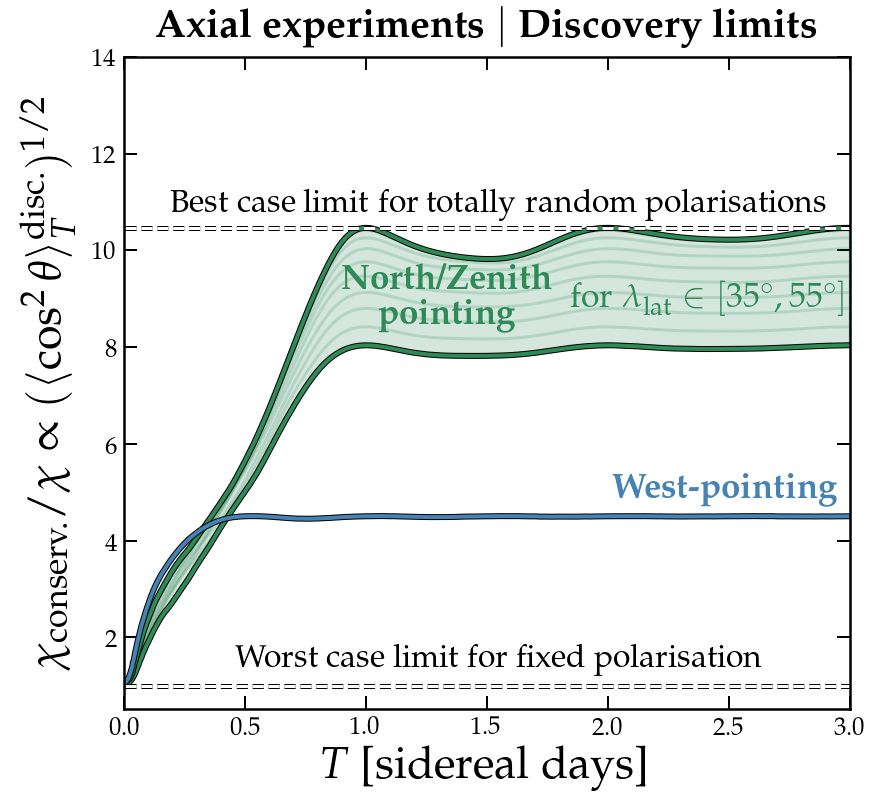

In [79]:
import matplotlib.colors as colors
import matplotlib.patheffects as pe

pek=[pe.Stroke(linewidth=6, foreground='k',alpha=1), pe.Normal()]
pek1=[pe.Stroke(linewidth=5, foreground='k',alpha=1), pe.Normal()]

fig,ax = MySquarePlot(r'$T$ [sidereal days]',r'$\chi_{\rm conserv.}/\chi \propto (\langle\cos^2{\theta}\rangle^{\rm disc.}_T)^{1/2}$')

Cmin = amin(CN_disc[:,0])

plt.fill_between(T,sqrt(CN_disc[0,:]*T)/sqrt(Cmin*T),y2=sqrt(CN_disc[-1,:]*T)/sqrt(Cmin*T),lw=3,color='seagreen',alpha=0.2)
for i in range(0,nlats):
    plt.plot(T,sqrt(CN_disc[i,:]*T)/sqrt(Cmin*T),'-',lw=3,color='seagreen',alpha=0.2)
    
plt.plot(T,sqrt(CN_disc[0,:]*T)/sqrt(Cmin*T),'-',lw=4,color='seagreen',path_effects=pek)
plt.plot(T,sqrt(CN_disc[-1,:]*T)/sqrt(Cmin*T),'-',lw=4,color='seagreen',path_effects=pek)

    
plt.plot(T,sqrt(CW_disc*T)/sqrt(Cmin*T),'-',color='steelblue',lw=4,path_effects=pek)


plt.plot(T,sqrt(0.3333*T)/sqrt(Cmin*T),'w--',lw=3,path_effects=pek1)
plt.plot(T,0*T+1,'w--',lw=3,path_effects=pek1)

plt.xlim(right=T[-1],left=0)
plt.ylim(top=14)
plt.gcf().text(0.00,0.1,'--',color='w')


plt.text(1.55,10.8,'Best case limit for totally random polarisations',ha='center',fontsize=32)
plt.text(1.55,1.4,'Worst case limit for fixed polarisation',ha='center',fontsize=32)

plt.text(2.95,4.9,r'{\bf West-pointing}',color='steelblue',fontsize=35,ha='right')
plt.text(1.34,9.2,r'{\bf North/Zenith}',fontsize=35,color='seagreen',ha='center')
plt.text(1.34,8.5,r'{\bf pointing}',fontsize=35,color='seagreen',ha='center')

plt.text(2.99,8.7,r' for $\lambda_{\rm lat} \in [35^\circ,55^\circ]$',fontsize=34,color='seagreen',ha='right')

plt.title(r'{\bf Axial experiments} $|$ {\bf Discovery limits}',fontsize=40,pad=20)
MySaveFig(fig,'Improvement_Axis')
print(amax(sqrt(CN_disc[-1,:]*T)/sqrt(Cmin*T)))

3.7497726219997736


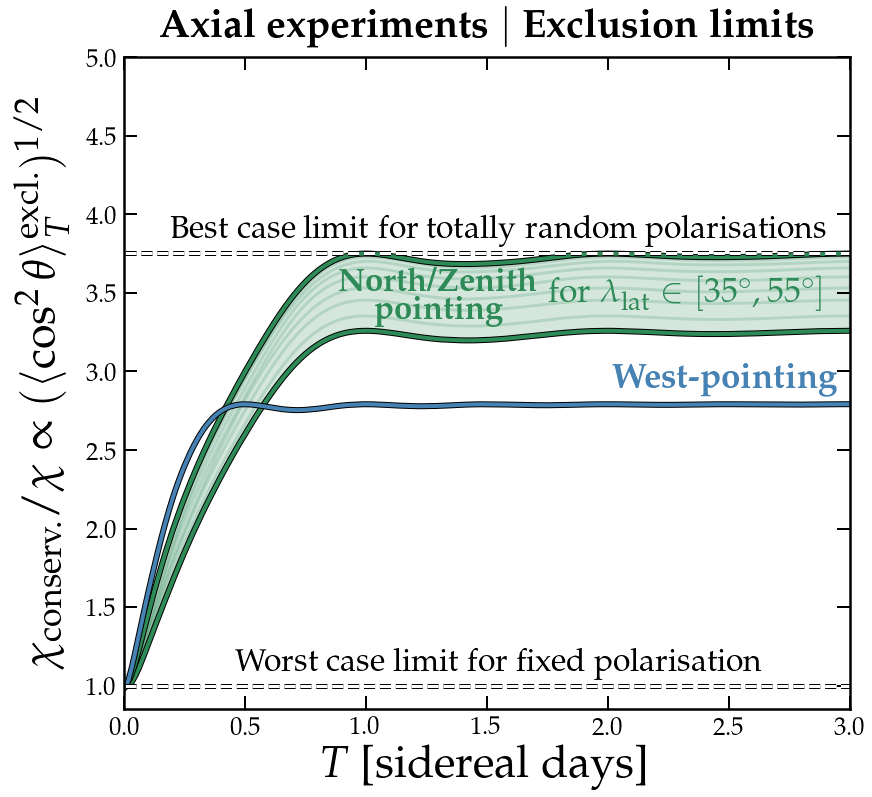

In [80]:
import matplotlib.colors as colors
import matplotlib.patheffects as pe

pek=[pe.Stroke(linewidth=6, foreground='k',alpha=1), pe.Normal()]
pek1=[pe.Stroke(linewidth=5, foreground='k',alpha=1), pe.Normal()]

fig,ax = MySquarePlot(r'$T$ [sidereal days]',r'$\chi_{\rm conserv.}/\chi \propto (\langle\cos^2{\theta}\rangle^{\rm excl.}_T)^{1/2}$')

Cmin = amin(CN_excl[:,0])

plt.fill_between(T,sqrt(CN_excl[0,:]*T)/sqrt(Cmin*T),y2=sqrt(CN_excl[-1,:]*T)/sqrt(Cmin*T),lw=3,color='seagreen',alpha=0.2)
for i in range(0,nlats):
    plt.plot(T,sqrt(CN_excl[i,:]*T)/sqrt(Cmin*T),'-',lw=3,color='seagreen',alpha=0.2)
    
plt.plot(T,sqrt(CN_excl[0,:]*T)/sqrt(Cmin*T),'-',lw=4,color='seagreen',path_effects=pek)
plt.plot(T,sqrt(CN_excl[-1,:]*T)/sqrt(Cmin*T),'-',lw=4,color='seagreen',path_effects=pek)

    
plt.plot(T,sqrt(CW_excl*T)/sqrt(Cmin*T),'-',color='steelblue',lw=4,path_effects=pek)


plt.plot(T,sqrt(0.3333*T)/sqrt(Cmin*T),'w--',lw=3,path_effects=pek1)
plt.plot(T,0*T+1,'w--',lw=3,path_effects=pek1)

plt.xlim(right=T[-1],left=0)
plt.ylim(top=5)
plt.gcf().text(0.00,0.1,'--',color='w')


plt.text(1.55,3.85,'Best case limit for totally random polarisations',ha='center',fontsize=32)
plt.text(1.55,1.1,'Worst case limit for fixed polarisation',ha='center',fontsize=32)

plt.text(2.95,2.9,r'{\bf West-pointing}',color='steelblue',fontsize=35,ha='right')
plt.text(1.3,3.51,r'{\bf North/Zenith}',fontsize=33,color='seagreen',ha='center')
plt.text(1.3,3.34,r'{\bf pointing}',fontsize=33,color='seagreen',ha='center')

plt.text(2.9,3.4,r' for $\lambda_{\rm lat} \in [35^\circ,55^\circ]$',fontsize=34,color='seagreen',ha='right')

plt.title(r'{\bf Axial experiments} $|$ {\bf Exclusion limits}',fontsize=40,pad=20)
MySaveFig(fig,'Improvement_Axis_excl')
print(amax(sqrt(CN_excl[-1,:]*T)/sqrt(Cmin*T)))

In [4]:
# Now just do the same for the planar experiments
nlats = 10
lats = linspace(35,55,nlats)
nt = 1000

CZW_excl = zeros(shape=(nlats,nt))
CZW_disc = zeros(shape=(nlats,nt))
for i in tqdm(range(0,nlats)):
    T,CZW_excl[i,:],CZW_disc[i,:] = costh_T_05(costh2ZW,lats[i],3,nt=nt)

T,CZN_excl,CZN_disc = costh_T_05(costh2ZN,45,3)

100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


In [87]:
amin(CW_disc)

0.003433299199500212

2.3719057298558752


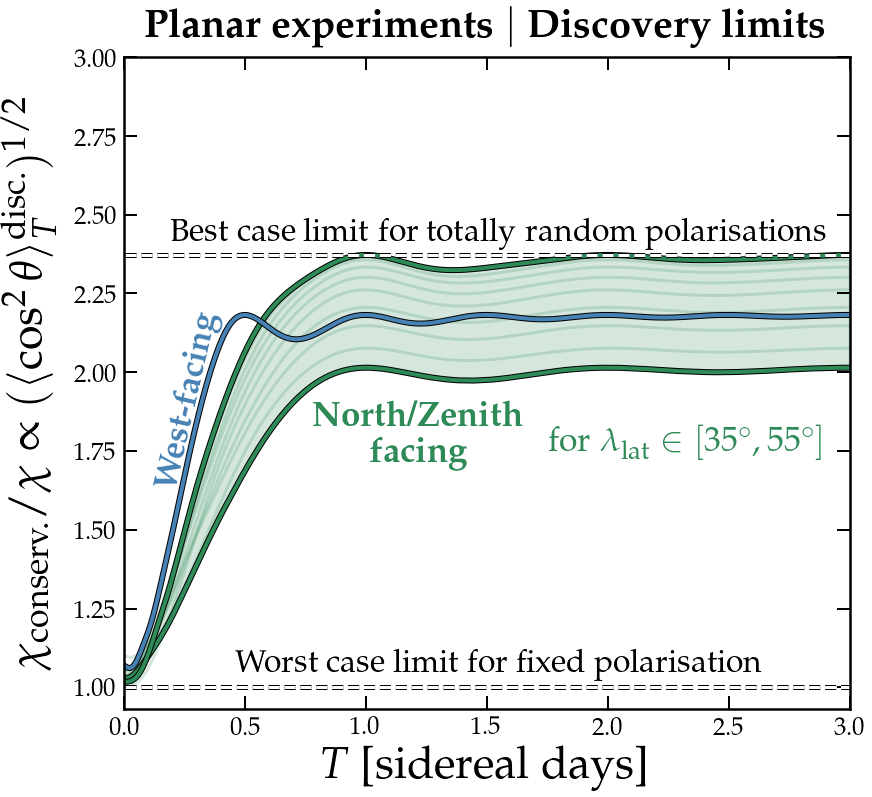

In [81]:
fig,ax = MySquarePlot(r'$T$ [sidereal days]',r'$\chi_{\rm conserv.}/\chi \propto (\langle\cos^2{\theta}\rangle^{\rm disc.}_T)^{1/2}$')

Cmin = amin(CZW_disc[:,0])

plt.fill_between(T,sqrt(CZW_disc[0,:]*T)/sqrt(Cmin*T),y2=sqrt(CZW_disc[-1,:]*T)/sqrt(Cmin*T),lw=3,color='seagreen',alpha=0.2)
for i in range(0,nlats):
    plt.plot(T,sqrt(CZW_disc[i,:]*T)/sqrt(Cmin*T),'-',lw=3,color='seagreen',alpha=0.2)
    
plt.plot(T,sqrt(CZW_disc[0,:]*T)/sqrt(Cmin*T),'-',lw=4,color='seagreen',path_effects=pek)
plt.plot(T,sqrt(CZW_disc[-1,:]*T)/sqrt(Cmin*T),'-',lw=4,color='seagreen',path_effects=pek)

    
plt.plot(T,sqrt(CZN_disc*T)/sqrt(Cmin*T),'-',color='steelblue',lw=4,path_effects=pek)



plt.plot(T,sqrt(0.6666*T)/sqrt(Cmin*T),'w--',lw=3,path_effects=pek1)
plt.plot(T,0*T+1,'w--',lw=3,path_effects=pek1)

plt.xlim(right=T[-1],left=0)
plt.ylim(top=3)
plt.gcf().text(0.00,0.1,'--',color='w')


plt.text(1.55,2.42,'Best case limit for totally random polarisations',ha='center',fontsize=32)
plt.text(1.55,1.05,'Worst case limit for fixed polarisation',ha='center',fontsize=32)
plt.text(0.42,1.65,r'{\bf West-facing}',rotation=77,color='steelblue',fontsize=34,ha='right')
plt.text(1.22,1.83,r'{\bf North/Zenith}',fontsize=35,color='seagreen',ha='center')
plt.text(1.22,1.72,r'{\bf facing}',fontsize=35,color='seagreen',ha='center')
plt.text(2.9,1.73,r' for $\lambda_{\rm lat} \in [35^\circ,55^\circ]$',fontsize=34,color='seagreen',ha='right')


plt.title(r'{\bf Planar experiments} $|$ {\bf Discovery limits}',fontsize=40,pad=20)

MySaveFig(fig,'Improvement_Plane')
print(amax(sqrt(CZW_disc[-1,:]*T)/sqrt(Cmin*T)))

1.3560194273441357


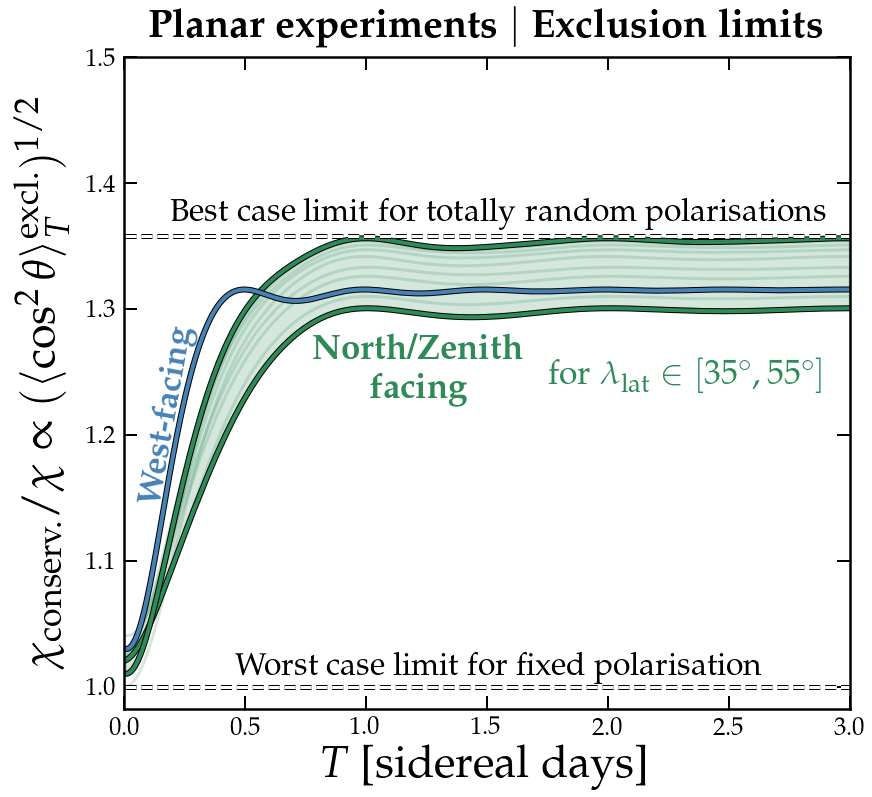

In [82]:
fig,ax = MySquarePlot(r'$T$ [sidereal days]',r'$\chi_{\rm conserv.}/\chi \propto (\langle\cos^2{\theta}\rangle^{\rm excl.}_T)^{1/2}$')

Cmin = amin(CZW_excl[:,0])

plt.fill_between(T,sqrt(CZW_excl[0,:]*T)/sqrt(Cmin*T),y2=sqrt(CZW_excl[-1,:]*T)/sqrt(Cmin*T),lw=3,color='seagreen',alpha=0.2)
for i in range(0,nlats):
    plt.plot(T,sqrt(CZW_excl[i,:]*T)/sqrt(Cmin*T),'-',lw=3,color='seagreen',alpha=0.2)
    
plt.plot(T,sqrt(CZW_excl[0,:]*T)/sqrt(Cmin*T),'-',lw=4,color='seagreen',path_effects=pek)
plt.plot(T,sqrt(CZW_excl[-1,:]*T)/sqrt(Cmin*T),'-',lw=4,color='seagreen',path_effects=pek)

    
plt.plot(T,sqrt(CZN_excl*T)/sqrt(Cmin*T),'-',color='steelblue',lw=4,path_effects=pek)



plt.plot(T,sqrt(0.6666*T)/sqrt(Cmin*T),'w--',lw=3,path_effects=pek1)
plt.plot(T,0*T+1,'w--',lw=3,path_effects=pek1)

plt.xlim(right=T[-1],left=0)
plt.ylim(top=1.5)
plt.gcf().text(0.00,0.1,'--',color='w')


plt.text(1.55,1.37,'Best case limit for totally random polarisations',ha='center',fontsize=32)
plt.text(1.55,1.01,'Worst case limit for fixed polarisation',ha='center',fontsize=32)
plt.text(0.315,1.15,r'{\bf West-facing}',rotation=80,color='steelblue',fontsize=34,ha='right')
plt.text(1.22,1.26,r'{\bf North/Zenith}',fontsize=35,color='seagreen',ha='center')
plt.text(1.22,1.23,r'{\bf facing}',fontsize=35,color='seagreen',ha='center')
plt.text(2.9,1.235,r' for $\lambda_{\rm lat} \in [35^\circ,55^\circ]$',fontsize=34,color='seagreen',ha='right')


plt.title(r'{\bf Planar experiments} $|$ {\bf Exclusion limits}',fontsize=40,pad=20)

MySaveFig(fig,'Improvement_Plane_excl')
print(amax(sqrt(CZW_excl[-1,:]*T)/sqrt(Cmin*T)))